# Bitcoin RNN Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_count', 'bitcoin_polarity_zeros', 'bitcoin_polarity', 'bitcoin_subjectivity', 'bitcoin_subjectivity_zeros', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

closePriceUsd    3.611949e+04
highPriceUsd     3.613191e+04
lowPriceUsd      3.544398e+04
volume           6.226012e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 48      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 48, 4)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 5s 226ms/step - loss: 1.3994 - val_loss: 0.7478
Epoch 2/20
13/13 [==============================] - 2s 158ms/step - loss: 0.1977 - val_loss: 1.0558
Epoch 3/20
13/13 [==============================] - 2s 141ms/step - loss: 0.2093 - val_loss: 0.9757
Epoch 4/20
13/13 [==============================] - 2s 144ms/step - loss: 0.2046 - val_loss: 1.1163
Epoch 5/20
13/13 [==============================] - 2s 147ms/step - loss: 0.1899 - val_loss: 0.6227
Epoch 6/20
13/13 [==============================] - 2s 146ms/step - loss: 0.1814 - val_loss: 0.7229
Epoch 7/20
13/13 [==============================] - 2s 194ms/step - loss: 0.1668 - val_loss: 0.7439
Epoch 8/20
13/13 [==============================] - 2s 148ms/step - loss: 0.1776 - val_loss: 0.6531
Epoch 9/20
13/13 [==============================] - 2s 132ms/step - loss: 0.1971 - val_loss: 0.5649
Epoch 10/20
13/13 [==============================] - 2s 145ms/step - loss: 0.1667 - val_loss: 0.5948

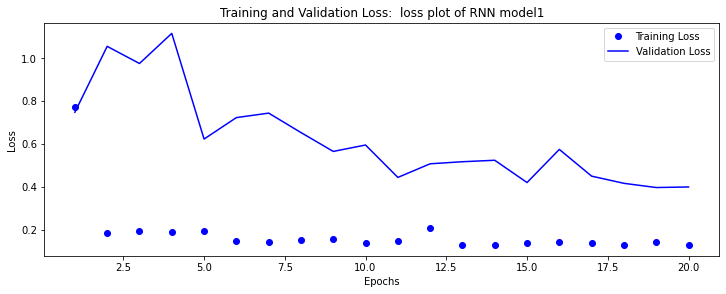

In [7]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 4s 172ms/step - loss: 1.4548 - val_loss: 0.3173
Epoch 2/20
13/13 [==============================] - 2s 168ms/step - loss: 0.2785 - val_loss: 0.4558
Epoch 3/20
13/13 [==============================] - 2s 170ms/step - loss: 0.2467 - val_loss: 0.7444
Epoch 4/20
13/13 [==============================] - 2s 159ms/step - loss: 0.2271 - val_loss: 0.6459
Epoch 5/20
13/13 [==============================] - 2s 184ms/step - loss: 0.2109 - val_loss: 0.6129
Epoch 6/20
13/13 [==============================] - 2s 161ms/step - loss: 0.1977 - val_loss: 0.7570
Epoch 7/20
13/13 [==============================] - 2s 158ms/step - loss: 0.2002 - val_loss: 0.8393
Epoch 8/20
13/13 [==============================] - 3s 217ms/step - loss: 0.2165 - val_loss: 0.7087
Epoch 9/20
13/13 [==============================] - 2s 172ms/step - loss: 0.2133 - val_loss: 0.6463
Epoch 10/20
13/13 [==============================] - 3s 218ms/step - loss: 0.2275 - val_loss: 0.5777

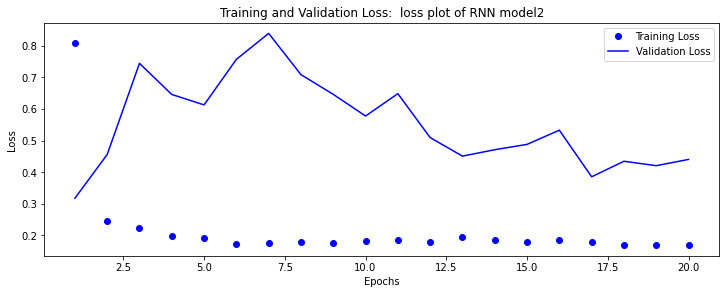

In [8]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 5s 275ms/step - loss: 1.2022 - val_loss: 0.5627
Epoch 2/30
13/13 [==============================] - 3s 218ms/step - loss: 0.1955 - val_loss: 0.6818
Epoch 3/30
13/13 [==============================] - 2s 128ms/step - loss: 0.1744 - val_loss: 0.5470
Epoch 4/30
13/13 [==============================] - 2s 123ms/step - loss: 0.1684 - val_loss: 0.5825
Epoch 5/30
13/13 [==============================] - 2s 137ms/step - loss: 0.1638 - val_loss: 0.5462
Epoch 6/30
13/13 [==============================] - 2s 141ms/step - loss: 0.1572 - val_loss: 0.5577
Epoch 7/30
13/13 [==============================] - 2s 118ms/step - loss: 0.1689 - val_loss: 0.5091
Epoch 8/30
13/13 [==============================] - 2s 133ms/step - loss: 0.1529 - val_loss: 0.4807
Epoch 9/30
13/13 [==============================] - 2s 131ms/step - loss: 0.1566 - val_loss: 0.5833
Epoch 10/30
13/13 [==============================] - 2s 186ms/step - loss: 0.1526 - val_loss: 0.4799

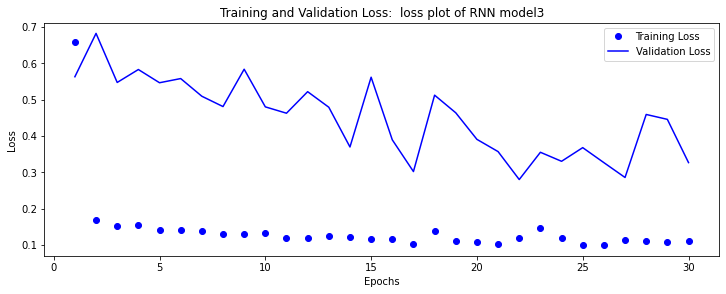

In [9]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 4s 177ms/step - loss: 1.0079 - val_loss: 0.8841
Epoch 2/30
13/13 [==============================] - 2s 192ms/step - loss: 0.2792 - val_loss: 0.9107
Epoch 3/30
13/13 [==============================] - 2s 156ms/step - loss: 0.2392 - val_loss: 0.9700
Epoch 4/30
13/13 [==============================] - 2s 135ms/step - loss: 0.2362 - val_loss: 0.9149
Epoch 5/30
13/13 [==============================] - 2s 152ms/step - loss: 0.2468 - val_loss: 0.7664
Epoch 6/30
13/13 [==============================] - 2s 164ms/step - loss: 0.2373 - val_loss: 0.6895
Epoch 7/30
13/13 [==============================] - 2s 144ms/step - loss: 0.2436 - val_loss: 0.6367
Epoch 8/30
13/13 [==============================] - 2s 146ms/step - loss: 0.2501 - val_loss: 0.6074
Epoch 9/30
13/13 [==============================] - 2s 147ms/step - loss: 0.2241 - val_loss: 0.5544
Epoch 10/30
13/13 [==============================] - 2s 163ms/step - loss: 0.2212 - val_loss: 0.5855

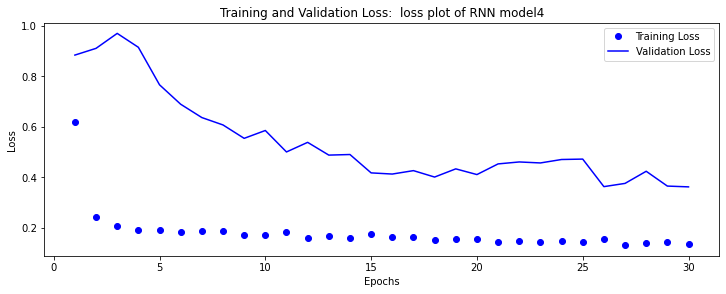

In [10]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 3s 137ms/step - loss: 1.0339 - val_loss: 0.4250
Epoch 2/30
13/13 [==============================] - 1s 115ms/step - loss: 0.2522 - val_loss: 0.3957
Epoch 3/30
13/13 [==============================] - 1s 112ms/step - loss: 0.1974 - val_loss: 0.4325
Epoch 4/30
13/13 [==============================] - 2s 134ms/step - loss: 0.1806 - val_loss: 0.4661
Epoch 5/30
13/13 [==============================] - 2s 122ms/step - loss: 0.1749 - val_loss: 0.4644
Epoch 6/30
13/13 [==============================] - 2s 120ms/step - loss: 0.1726 - val_loss: 0.4482
Epoch 7/30
13/13 [==============================] - 2s 129ms/step - loss: 0.1690 - val_loss: 0.4321
Epoch 8/30
13/13 [==============================] - 2s 168ms/step - loss: 0.1629 - val_loss: 0.4145
Epoch 9/30
13/13 [==============================] - 2s 130ms/step - loss: 0.1590 - val_loss: 0.3889
Epoch 10/30
13/13 [==============================] - 2s 122ms/step - loss: 0.1599 - val_loss: 0.3557

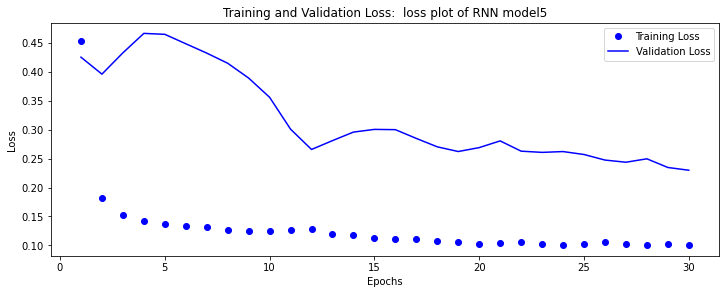

In [11]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 4s 145ms/step - loss: 0.9812 - val_loss: 0.7586
Epoch 2/30
13/13 [==============================] - 2s 128ms/step - loss: 0.3354 - val_loss: 0.7532
Epoch 3/30
13/13 [==============================] - 1s 106ms/step - loss: 0.2648 - val_loss: 0.8410
Epoch 4/30
13/13 [==============================] - 2s 177ms/step - loss: 0.2527 - val_loss: 0.8117
Epoch 5/30
13/13 [==============================] - 2s 126ms/step - loss: 0.2540 - val_loss: 0.7940
Epoch 6/30
13/13 [==============================] - 3s 208ms/step - loss: 0.2310 - val_loss: 0.6715
Epoch 7/30
13/13 [==============================] - 2s 146ms/step - loss: 0.2452 - val_loss: 0.7009
Epoch 8/30
13/13 [==============================] - 2s 117ms/step - loss: 0.2259 - val_loss: 0.6756
Epoch 9/30
13/13 [==============================] - 1s 113ms/step - loss: 0.2315 - val_loss: 0.6155
Epoch 10/30
13/13 [==============================] - 2s 123ms/step - loss: 0.2109 - val_loss: 0.6006

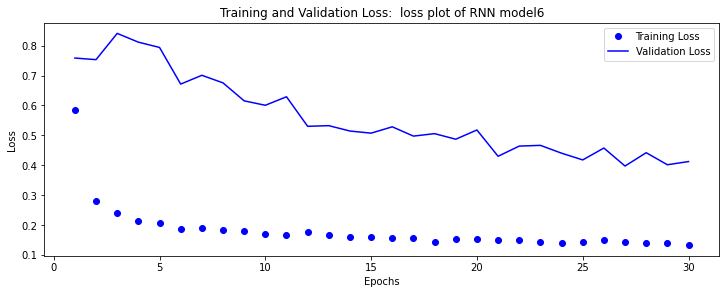

In [12]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 3s 128ms/step - loss: 0.6923 - val_loss: 0.2289
Epoch 2/40
13/13 [==============================] - 1s 111ms/step - loss: 0.2001 - val_loss: 0.3370
Epoch 3/40
13/13 [==============================] - 1s 112ms/step - loss: 0.1906 - val_loss: 0.3289
Epoch 4/40
13/13 [==============================] - 1s 112ms/step - loss: 0.1791 - val_loss: 0.3046
Epoch 5/40
13/13 [==============================] - 1s 109ms/step - loss: 0.1689 - val_loss: 0.2937
Epoch 6/40
13/13 [==============================] - 1s 91ms/step - loss: 0.1587 - val_loss: 0.2962
Epoch 7/40
13/13 [==============================] - 1s 107ms/step - loss: 0.1510 - val_loss: 0.2998
Epoch 8/40
13/13 [==============================] - 1s 95ms/step - loss: 0.1450 - val_loss: 0.2968
Epoch 9/40
13/13 [==============================] - 2s 165ms/step - loss: 0.1413 - val_loss: 0.2945
Epoch 10/40
13/13 [==============================] - 1s 114ms/step - loss: 0.1387 - val_loss: 0.2891
E

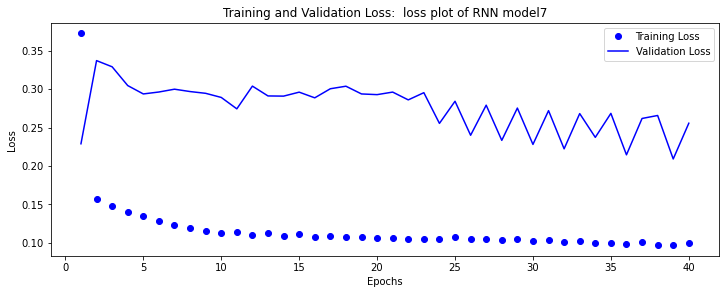

In [13]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 4s 170ms/step - loss: 0.5594 - val_loss: 0.4684
Epoch 2/30
13/13 [==============================] - 2s 119ms/step - loss: 0.3606 - val_loss: 0.4053
Epoch 3/30
13/13 [==============================] - 1s 116ms/step - loss: 0.3143 - val_loss: 0.3800
Epoch 4/30
13/13 [==============================] - 1s 117ms/step - loss: 0.2604 - val_loss: 0.3297
Epoch 5/30
13/13 [==============================] - 2s 124ms/step - loss: 0.2471 - val_loss: 0.3516
Epoch 6/30
13/13 [==============================] - 2s 119ms/step - loss: 0.2370 - val_loss: 0.3028
Epoch 7/30
13/13 [==============================] - 2s 133ms/step - loss: 0.2261 - val_loss: 0.3012
Epoch 8/30
13/13 [==============================] - 2s 126ms/step - loss: 0.2115 - val_loss: 0.3063
Epoch 9/30
13/13 [==============================] - 2s 119ms/step - loss: 0.2008 - val_loss: 0.2906
Epoch 10/30
13/13 [==============================] - 2s 172ms/step - loss: 0.2097 - val_loss: 0.3057

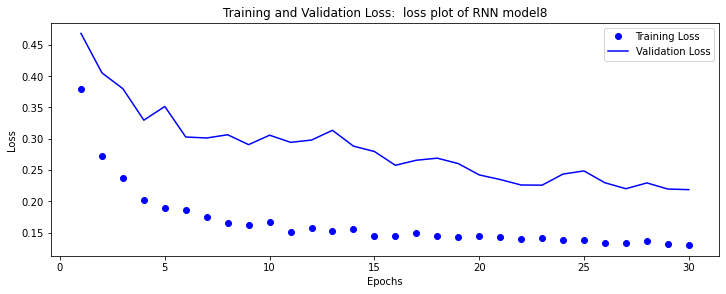

In [14]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 3s 129ms/step - loss: 1.2795 - val_loss: 0.3192
Epoch 2/20
13/13 [==============================] - 1s 108ms/step - loss: 0.3863 - val_loss: 0.2282
Epoch 3/20
13/13 [==============================] - 1s 99ms/step - loss: 0.2670 - val_loss: 0.2122
Epoch 4/20
13/13 [==============================] - 1s 110ms/step - loss: 0.2108 - val_loss: 0.2137
Epoch 5/20
13/13 [==============================] - 1s 116ms/step - loss: 0.1910 - val_loss: 0.2145
Epoch 6/20
13/13 [==============================] - 2s 120ms/step - loss: 0.1804 - val_loss: 0.2118
Epoch 7/20
13/13 [==============================] - 2s 150ms/step - loss: 0.1717 - val_loss: 0.2086
Epoch 8/20
13/13 [==============================] - 1s 109ms/step - loss: 0.1651 - val_loss: 0.2046
Epoch 9/20
13/13 [==============================] - 2s 138ms/step - loss: 0.1600 - val_loss: 0.2001
Epoch 10/20
13/13 [==============================] - 2s 125ms/step - loss: 0.1557 - val_loss: 0.1956


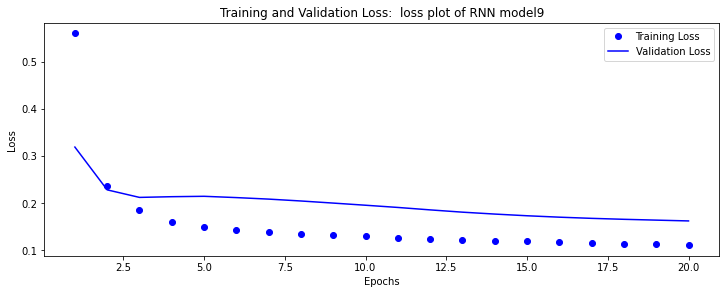

In [15]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 3s 124ms/step - loss: 1.9228 - val_loss: 0.4433
Epoch 2/20
13/13 [==============================] - 2s 122ms/step - loss: 0.6925 - val_loss: 0.4191
Epoch 3/20
13/13 [==============================] - 1s 102ms/step - loss: 0.4950 - val_loss: 0.3866
Epoch 4/20
13/13 [==============================] - 2s 119ms/step - loss: 0.4279 - val_loss: 0.3482
Epoch 5/20
13/13 [==============================] - 2s 164ms/step - loss: 0.3416 - val_loss: 0.3014
Epoch 6/20
13/13 [==============================] - 2s 122ms/step - loss: 0.3193 - val_loss: 0.2546
Epoch 7/20
13/13 [==============================] - 2s 124ms/step - loss: 0.2857 - val_loss: 0.2570
Epoch 8/20
13/13 [==============================] - 2s 127ms/step - loss: 0.2659 - val_loss: 0.2433
Epoch 9/20
13/13 [==============================] - 2s 137ms/step - loss: 0.2595 - val_loss: 0.2300
Epoch 10/20
13/13 [==============================] - 2s 112ms/step - loss: 0.2560 - val_loss: 0.2157

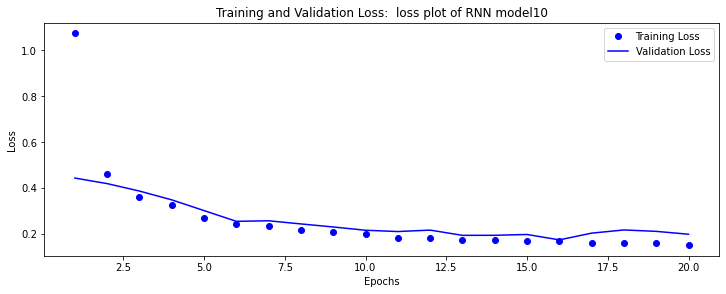

In [16]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 4s 190ms/step - loss: 1.0770 - val_loss: 0.3017
Epoch 2/40
13/13 [==============================] - 2s 125ms/step - loss: 0.7471 - val_loss: 0.3321
Epoch 3/40
13/13 [==============================] - 2s 122ms/step - loss: 0.5969 - val_loss: 0.3444
Epoch 4/40
13/13 [==============================] - 1s 101ms/step - loss: 0.5107 - val_loss: 0.3657
Epoch 5/40
13/13 [==============================] - 1s 118ms/step - loss: 0.4971 - val_loss: 0.3714
Epoch 6/40
13/13 [==============================] - 2s 131ms/step - loss: 0.4403 - val_loss: 0.3820
Epoch 7/40
13/13 [==============================] - 2s 129ms/step - loss: 0.4121 - val_loss: 0.3798
Epoch 8/40
13/13 [==============================] - 2s 148ms/step - loss: 0.3837 - val_loss: 0.3679
Epoch 9/40
13/13 [==============================] - 2s 171ms/step - loss: 0.3625 - val_loss: 0.3577
Epoch 10/40
13/13 [==============================] - 2s 127ms/step - loss: 0.3477 - val_loss: 0.3513

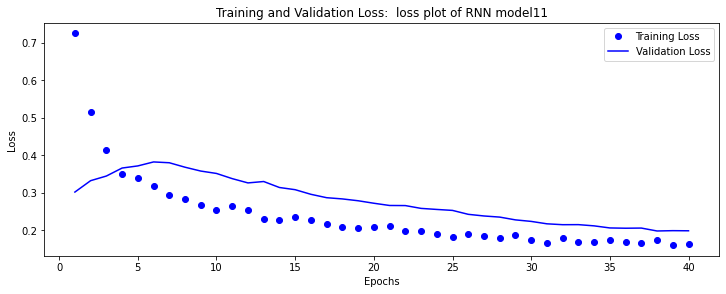

In [17]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 6s 285ms/step - loss: 1.5510 - val_loss: 0.8906
Epoch 2/30
13/13 [==============================] - 2s 158ms/step - loss: 0.4771 - val_loss: 0.8876
Epoch 3/30
13/13 [==============================] - 2s 159ms/step - loss: 0.3798 - val_loss: 0.8820
Epoch 4/30
13/13 [==============================] - 3s 187ms/step - loss: 0.3421 - val_loss: 0.9768
Epoch 5/30
13/13 [==============================] - 2s 145ms/step - loss: 0.3050 - val_loss: 0.9361
Epoch 6/30
13/13 [==============================] - 2s 137ms/step - loss: 0.3095 - val_loss: 0.8207
Epoch 7/30
13/13 [==============================] - 2s 149ms/step - loss: 0.2542 - val_loss: 0.7407
Epoch 8/30
13/13 [==============================] - 2s 151ms/step - loss: 0.2496 - val_loss: 0.6378
Epoch 9/30
13/13 [==============================] - 2s 164ms/step - loss: 0.2691 - val_loss: 0.6099
Epoch 10/30
13/13 [==============================] - 3s 200ms/step - loss: 0.2605 - val_loss: 0.6043

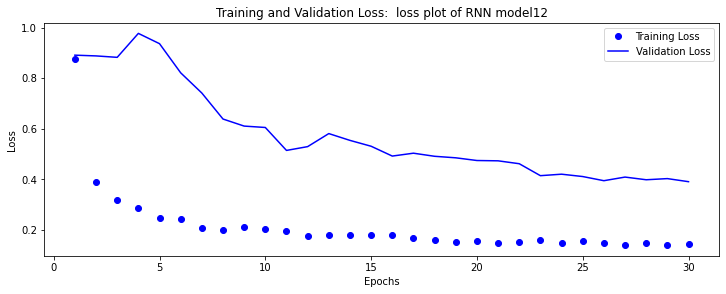

In [18]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 8s 276ms/step - loss: 1.2858 - val_loss: 1.2775
Epoch 2/30
13/13 [==============================] - 2s 163ms/step - loss: 0.4129 - val_loss: 1.0251
Epoch 3/30
13/13 [==============================] - 2s 162ms/step - loss: 0.3581 - val_loss: 0.9642
Epoch 4/30
13/13 [==============================] - 2s 165ms/step - loss: 0.3406 - val_loss: 0.9864
Epoch 5/30
13/13 [==============================] - 3s 223ms/step - loss: 0.3670 - val_loss: 0.6666
Epoch 6/30
13/13 [==============================] - 2s 191ms/step - loss: 0.2998 - val_loss: 0.8109
Epoch 7/30
13/13 [==============================] - 2s 159ms/step - loss: 0.3031 - val_loss: 0.7587
Epoch 8/30
13/13 [==============================] - 2s 167ms/step - loss: 0.2856 - val_loss: 0.7446
Epoch 9/30
13/13 [==============================] - 2s 161ms/step - loss: 0.2972 - val_loss: 0.5458
Epoch 10/30
13/13 [==============================] - 2s 157ms/step - loss: 0.2710 - val_loss: 0.6130

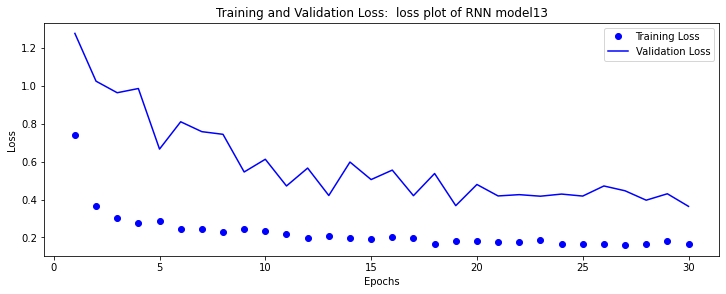

In [19]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 4s 180ms/step - loss: 0.8236 - val_loss: 0.2484
Epoch 2/20
13/13 [==============================] - 2s 181ms/step - loss: 0.2083 - val_loss: 0.2403
Epoch 3/20
13/13 [==============================] - 3s 196ms/step - loss: 0.1760 - val_loss: 0.2501
Epoch 4/20
13/13 [==============================] - 1s 118ms/step - loss: 0.1580 - val_loss: 0.2688
Epoch 5/20
13/13 [==============================] - 2s 172ms/step - loss: 0.1506 - val_loss: 0.3062
Epoch 6/20
13/13 [==============================] - 2s 125ms/step - loss: 0.1613 - val_loss: 0.3111
Epoch 7/20
13/13 [==============================] - 2s 168ms/step - loss: 0.1640 - val_loss: 0.2783
Epoch 8/20
13/13 [==============================] - 2s 123ms/step - loss: 0.1551 - val_loss: 0.2724
Epoch 9/20
13/13 [==============================] - 1s 107ms/step - loss: 0.1503 - val_loss: 0.2532
Epoch 10/20
13/13 [==============================] - 1s 104ms/step - loss: 0.1521 - val_loss: 0.2556

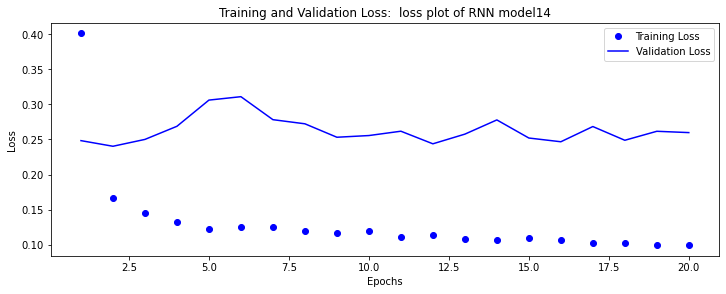

In [20]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 3s 141ms/step - loss: 0.5247 - val_loss: 0.3213
Epoch 2/20
13/13 [==============================] - 1s 108ms/step - loss: 0.2565 - val_loss: 0.2439
Epoch 3/20
13/13 [==============================] - 1s 119ms/step - loss: 0.2153 - val_loss: 0.2239
Epoch 4/20
13/13 [==============================] - 1s 111ms/step - loss: 0.1968 - val_loss: 0.2173
Epoch 5/20
13/13 [==============================] - 1s 113ms/step - loss: 0.1851 - val_loss: 0.2144
Epoch 6/20
13/13 [==============================] - 1s 108ms/step - loss: 0.1760 - val_loss: 0.2123
Epoch 7/20
13/13 [==============================] - 2s 120ms/step - loss: 0.1682 - val_loss: 0.2105
Epoch 8/20
13/13 [==============================] - 1s 114ms/step - loss: 0.1614 - val_loss: 0.2092
Epoch 9/20
13/13 [==============================] - 1s 88ms/step - loss: 0.1554 - val_loss: 0.2084
Epoch 10/20
13/13 [==============================] - 1s 105ms/step - loss: 0.1503 - val_loss: 0.2083


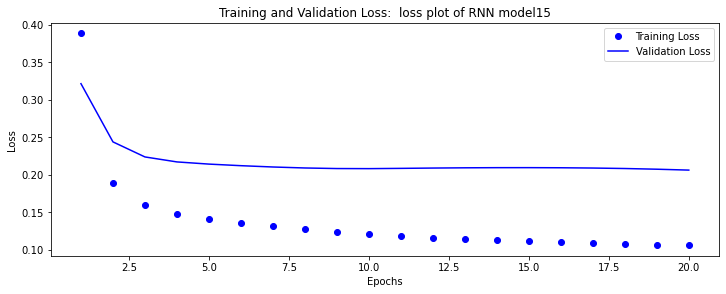

In [21]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 3s 147ms/step - loss: 1.1495 - val_loss: 0.4101
Epoch 2/20
13/13 [==============================] - 2s 118ms/step - loss: 0.2258 - val_loss: 0.3768
Epoch 3/20
13/13 [==============================] - 2s 155ms/step - loss: 0.1841 - val_loss: 0.4025
Epoch 4/20
13/13 [==============================] - 2s 120ms/step - loss: 0.1671 - val_loss: 0.4769
Epoch 5/20
13/13 [==============================] - 2s 134ms/step - loss: 0.1823 - val_loss: 0.4585
Epoch 6/20
13/13 [==============================] - 1s 101ms/step - loss: 0.1917 - val_loss: 0.3936
Epoch 7/20
13/13 [==============================] - 2s 156ms/step - loss: 0.1877 - val_loss: 0.3422
Epoch 8/20
13/13 [==============================] - 2s 123ms/step - loss: 0.1725 - val_loss: 0.3139
Epoch 9/20
13/13 [==============================] - 2s 131ms/step - loss: 0.1698 - val_loss: 0.2879
Epoch 10/20
13/13 [==============================] - 2s 166ms/step - loss: 0.1650 - val_loss: 0.2647

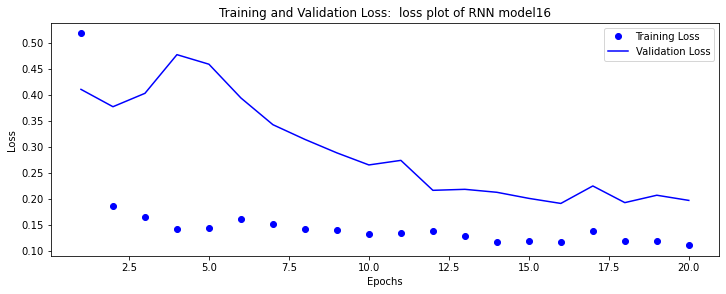

In [22]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 5s 153ms/step - loss: 0.8856 - val_loss: 0.4259
Epoch 2/20
13/13 [==============================] - 2s 125ms/step - loss: 0.2457 - val_loss: 0.5090
Epoch 3/20
13/13 [==============================] - 2s 171ms/step - loss: 0.2325 - val_loss: 0.5028
Epoch 4/20
13/13 [==============================] - 2s 129ms/step - loss: 0.2158 - val_loss: 0.4482
Epoch 5/20
13/13 [==============================] - 2s 193ms/step - loss: 0.2333 - val_loss: 0.3929
Epoch 6/20
13/13 [==============================] - 1s 117ms/step - loss: 0.1872 - val_loss: 0.3854
Epoch 7/20
13/13 [==============================] - 1s 117ms/step - loss: 0.1692 - val_loss: 0.3959
Epoch 8/20
13/13 [==============================] - 2s 131ms/step - loss: 0.1602 - val_loss: 0.4358
Epoch 9/20
13/13 [==============================] - 2s 129ms/step - loss: 0.1676 - val_loss: 0.3790
Epoch 10/20
13/13 [==============================] - 1s 115ms/step - loss: 0.1546 - val_loss: 0.3850

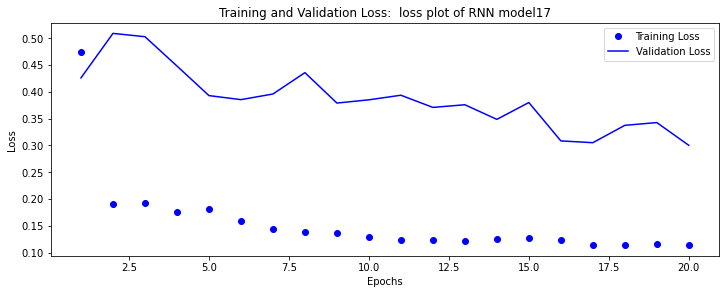

In [23]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 4s 146ms/step - loss: 1.4839 - val_loss: 0.2364
Epoch 2/20
13/13 [==============================] - 1s 109ms/step - loss: 0.2670 - val_loss: 0.3188
Epoch 3/20
13/13 [==============================] - 1s 115ms/step - loss: 0.2100 - val_loss: 0.3346
Epoch 4/20
13/13 [==============================] - 2s 183ms/step - loss: 0.1822 - val_loss: 0.3234
Epoch 5/20
13/13 [==============================] - 1s 117ms/step - loss: 0.1725 - val_loss: 0.3093
Epoch 6/20
13/13 [==============================] - 2s 175ms/step - loss: 0.1644 - val_loss: 0.3002
Epoch 7/20
13/13 [==============================] - 2s 122ms/step - loss: 0.1580 - val_loss: 0.2986
Epoch 8/20
13/13 [==============================] - 1s 106ms/step - loss: 0.1531 - val_loss: 0.2992
Epoch 9/20
13/13 [==============================] - 2s 119ms/step - loss: 0.1505 - val_loss: 0.2944
Epoch 10/20
13/13 [==============================] - 2s 122ms/step - loss: 0.1484 - val_loss: 0.2789

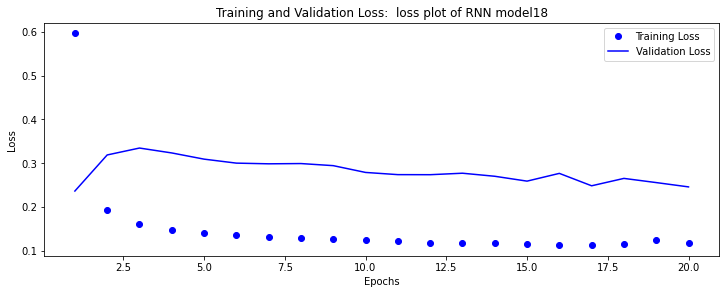

In [24]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")

In [25]:
def lowest_val_loss_and_epoch(history):
    lowest_val_loss = -1
    lowest_epoch = 0
    for i in range(0, len(history.history['val_loss'])) :
        epoch = i+1
        val_loss = history.history['val_loss'][i]
        if lowest_val_loss == -1  or val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            lowest_epoch = epoch
    return lowest_val_loss, lowest_epoch

histories = [RNN_model1_history, RNN_model2_history, RNN_model3_history, RNN_model4_history, RNN_model5_history, RNN_model6_history, RNN_model7_history, RNN_model8_history, RNN_model9_history, RNN_model10_history, RNN_model11_history, RNN_model12_history, RNN_model13_history, RNN_model14_history, RNN_model15_history, RNN_model16_history, RNN_model17_history, RNN_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.39616915583610535, epoch: 19
Model 2: min val loss: 0.3173069655895233, epoch: 1
Model 3: min val loss: 0.2801608145236969, epoch: 22
Model 4: min val loss: 0.36223629117012024, epoch: 30
Model 5: min val loss: 0.22981096804141998, epoch: 30
Model 6: min val loss: 0.3975455164909363, epoch: 27
Model 7: min val loss: 0.20916606485843658, epoch: 39
Model 8: min val loss: 0.21861280500888824, epoch: 30
Model 9: min val loss: 0.16222083568572998, epoch: 20
Model 10: min val loss: 0.1737551987171173, epoch: 16
Model 11: min val loss: 0.1979648917913437, epoch: 38
Model 12: min val loss: 0.38978415727615356, epoch: 30
Model 13: min val loss: 0.36422744393348694, epoch: 30
Model 14: min val loss: 0.24033135175704956, epoch: 2
Model 15: min val loss: 0.20638026297092438, epoch: 20
Model 16: min val loss: 0.19068576395511627, epoch: 16
Model 17: min val loss: 0.3001004755496979, epoch: 20
Model 18: min val loss: 0.23637767136096954, epoch: 1
